In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:

data_transforms = {
    'TRAIN': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'TEST': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}
data_dir = 'DATASET'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['TRAIN', 'TEST']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['TRAIN', 'TEST']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['TRAIN', 'TEST']}
class_names = image_datasets['TRAIN'].classes

print(f"Classes: {class_names}")


Classes: ['O', 'R']


In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)


In [7]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['TRAIN', 'TEST']:
            if phase == 'TRAIN':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'TRAIN'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'TRAIN':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

model = train_model(model, criterion, optimizer, num_epochs=10)


In [8]:
def evaluate_model(model):
    model.eval()
    running_corrects = 0

    for inputs, labels in dataloaders['TEST']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / dataset_sizes['TEST']
    print(f'Test Accuracy: {acc:.4f}')

evaluate_model(model)


Test Accuracy: 0.9347


In [9]:
model_save_path = '/Users/Sauhard/Downloads/CV Model/model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to /Users/Sauhard/Downloads/CV Model/model.pth


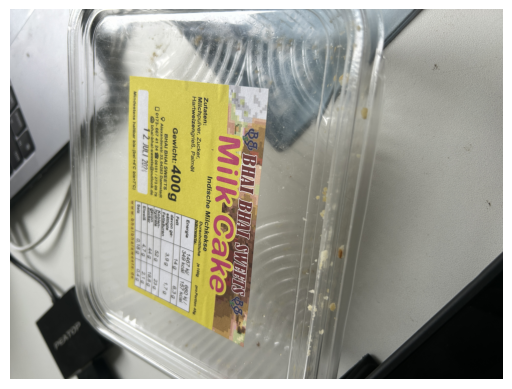

recyclable


In [7]:

model_load_path = '/Users/Sauhard/Downloads/CV Model/model.pth'
model = models.resnet18(weights=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(model_load_path))
model = model.to(device)
model.eval()
image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    image = image_transforms(image)
    image = image.unsqueeze(0)  
    image = image.to(device)
    
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    
    class_names = ['organic', 'recyclable']
    prediction = class_names[preds.item()]
    return prediction

image_path = 'liveset/IMG_0078.JPG'  
prediction = predict_image(image_path)
print(prediction)

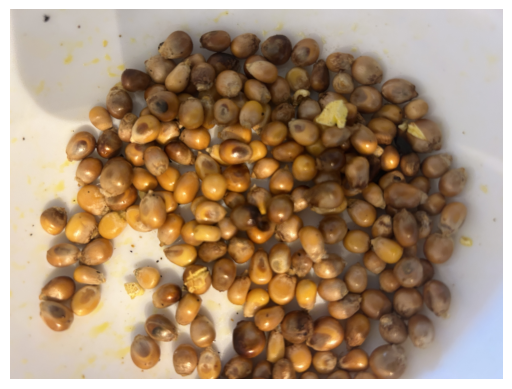

organic


In [11]:
image_path = 'IMG_0079.JPG'  
prediction = predict_image(image_path)
print(prediction)

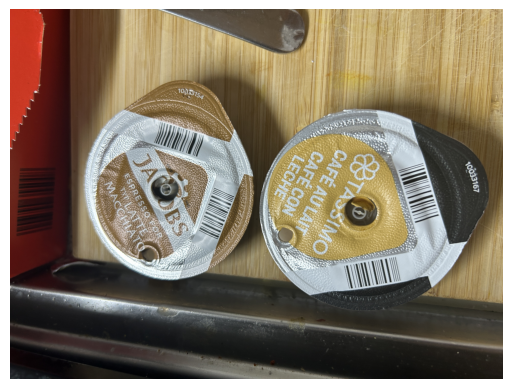

recyclable


In [12]:
image_path = 'IMG_0080.JPG'  
prediction = predict_image(image_path)
print(prediction)

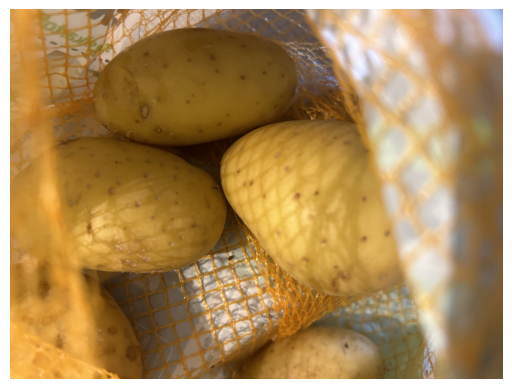

organic


In [13]:

image_path = 'IMG_0081.JPG'  
prediction = predict_image(image_path)
print(prediction)